In [2]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
def load_from_output(path:str):
    U={}
    with open(path,"r") as file:
        for line in file.readlines():
            number=R"([0-9]+\.[0-9]+)"
            word=R"([a-zA-Z_]+)"
            match=re.match(fR"\d+/\d+[^\w]+\w+ \w+/\w+[^\w]+{word}: {number}[^\w]+{word}: {number}[^\w]+{word}: {number}[^\w]+{word}: {number}",line)
            if match:
                for k in range(4):
                    matched_word=match.group(2*k+1)
                    matched_number=match.group(2*k+2)
                    if matched_word not in U:
                        U[matched_word]=[]
                    U[matched_word].append(float(matched_number))
    return U


def load_emission_data(path:str):
    U=pd.read_csv(path)
    U.rename({"project_name":"name"},inplace=True,axis="columns")
    return U
    

## 1. Results using DCT Model

In [80]:
AbcResults=pd.DataFrame(load_from_output("results/AudioMNIST/ABCNet.txt"))
XnorResults=pd.DataFrame(load_from_output("results/AudioMNIST/XnorNet.txt"))
BinaryResults=pd.DataFrame(load_from_output("results/AudioMNIST/BinaryNet.txt"))
CNNResults=pd.read_json("results/AudioMNIST/CNNSpectralOnly.json")
CNNResults=pd.concat([CNNResults,*[CNNResults.tail(1) for k in np.arange(CNNResults.shape[0],AbcResults.shape[0])]],ignore_index=True)
datasets=[AbcResults,XnorResults,BinaryResults,CNNResults]
for dataset,name in zip(datasets,["ABCNet","XnorNet","BinaryNet","CNN"]):
    dataset["epoch"]=np.arange(dataset.shape[0])
    dataset["name"]=name
    dataset["best_val_accuracy"]=dataset["val_accuracy"].cummax()
results=pd.concat(datasets,ignore_index=True)

<AxesSubplot:xlabel='epoch', ylabel='best_val_accuracy'>

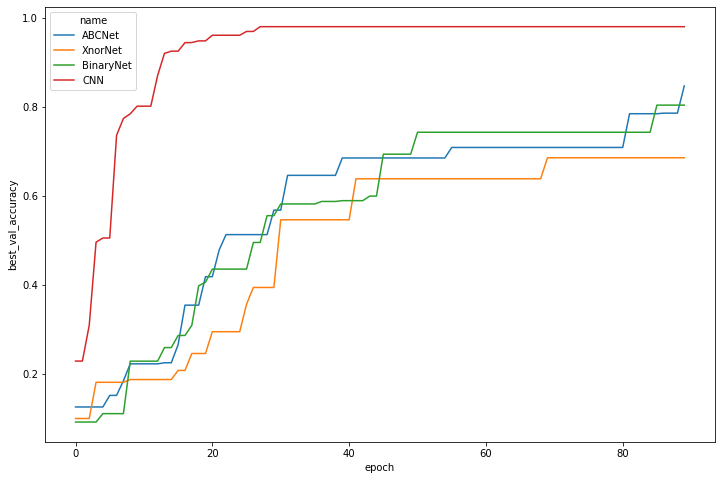

In [81]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data=results,x="epoch",y="best_val_accuracy",hue="name")

(0.0, 50.0)

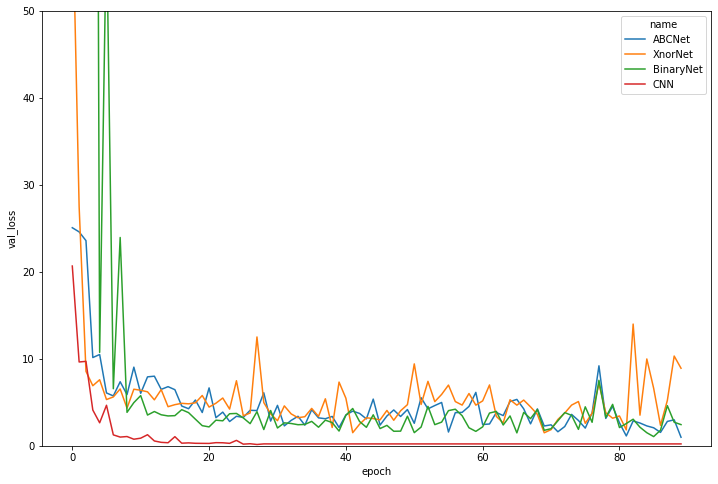

In [91]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data=results,x="epoch",y="val_loss",hue="name")
ax.set_ylim((0,50))

<AxesSubplot:xlabel='epoch', ylabel='loss'>

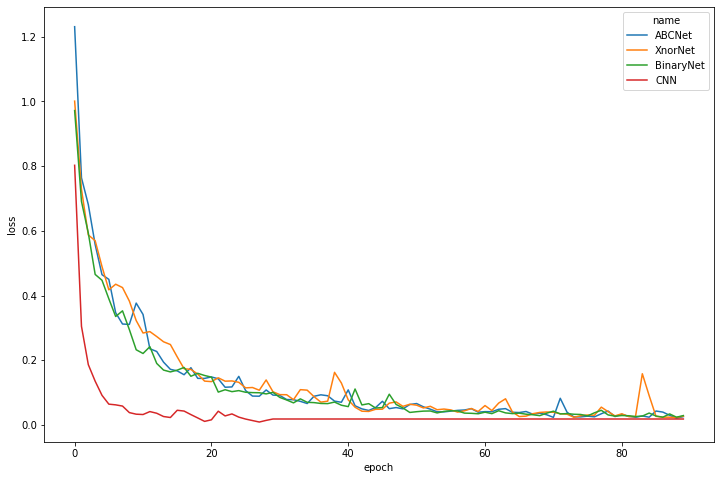

In [96]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data=results,x="epoch",y="loss",hue="name")

In [143]:
des=results.groupby("name").describe()
des.drop([(col,metric) for col,metric in des.columns if metric not in ["max","min"]],axis="columns")

loss            accuracy            val_loss             \
                min       max       min       max       min        max   
name                                                                     
ABCNet     0.020500  1.231200  0.597800  0.993300  0.982400   25.07390   
BinaryNet  0.023700  0.971800  0.684600  0.992200  1.058300  468.68930   
CNN        0.008747  0.802624  0.754178  0.997511  0.150742   20.66736   
XnorNet    0.023000  1.001000  0.665300  0.992500  1.495200   63.25030   

          val_accuracy           epoch       best_val_accuracy            
                   min       max   min   max               min       max  
name                                                                      
ABCNet          0.1008  0.846900   0.0  89.0          0.126300  0.846900  
BinaryNet       0.0925  0.803700   0.0  89.0          0.092500  0.803700  
CNN             0.2276  0.979733   0.0  89.0          0.229333  0.979733  
XnorNet         0.0991  0.685600   0.0  89.0          0.100400  0.685600

In [137]:
a,b=des.columns[0]

## 2. Results using MFCC Model

In [110]:
AbcResults=pd.DataFrame(load_from_output("results/AudioMNIST/MFCC/ABCNet.txt"))
XnorResults=pd.DataFrame(load_from_output("results/AudioMNIST/MFCC/XnorNet.txt"))
BinaryResults=pd.DataFrame(load_from_output("results/AudioMNIST/MFCC/BinaryNet.txt"))
CNNResults=pd.DataFrame(load_from_output("results/AudioMNIST/MFCC/CNN.txt"))
datasets=[AbcResults,XnorResults,BinaryResults,CNNResults]
for dataset,name in zip(datasets,["ABCNet","XnorNet","BinaryNet","CNN"]):
    dataset["epoch"]=np.arange(dataset.shape[0])
    dataset["name"]=name
    dataset["best_val_accuracy"]=dataset["val_accuracy"].cummax()

run_results=pd.concat(datasets,ignore_index=True)
emission_results=load_emission_data("results/AudioMNIST/MFCC/emissions.csv")
emission_results=emission_results[emission_results["name"]!="codecarbon"]
results=pd.merge(run_results,emission_results,on="name")
results.sample(3)

,loss,accuracy,val_loss,val_accuracy,epoch,name,best_val_accuracy,timestamp,run_id,duration,...,python_version,cpu_count,cpu_model,gpu_count,gpu_model,longitude,latitude,ram_total_size,tracking_mode,on_cloud
230,0.0847,0.9763,0.7602,0.8569,50,BinaryNet,0.8702,2022-08-26T17:36:44,95e9bca6-3c69-4d1c-a88c-f8b77f7d411d,101.645334,...,3.9.13,16,AMD Ryzen 7 4800H with Radeon Graphics,1,1 x NVIDIA GeForce GTX 1660 Ti,9.4613,34.4739,31.216187,machine,N
279,0.0271,0.9929,3.2829,0.4916,9,CNN,0.7933,2022-08-26T17:31:17,141f69ca-220a-4fba-95e6-8eb9441f2243,87.213604,...,3.9.13,16,AMD Ryzen 7 4800H with Radeon Graphics,1,1 x NVIDIA GeForce GTX 1660 Ti,9.4613,34.4739,31.216187,machine,N
225,0.0466,0.9880,1.1078,0.7600,45,BinaryNet,0.8702,2022-08-26T17:36:44,95e9bca6-3c69-4d1c-a88c-f8b77f7d411d,101.645334,...,3.9.13,16,AMD Ryzen 7 4800H with Radeon Graphics,1,1 x NVIDIA GeForce GTX 1660 Ti,9.4613,34.4739,31.216187,machine,N


In [136]:
results[["name","val_accuracy"]].groupby("name").max()

,val_accuracy
name,
ABCNet,0.9449
BinaryNet,0.9231
CNN,0.9627
XnorNet,0.9253


Text(0.5, 1.0, 'Best validation accuracy as a function of epoch')

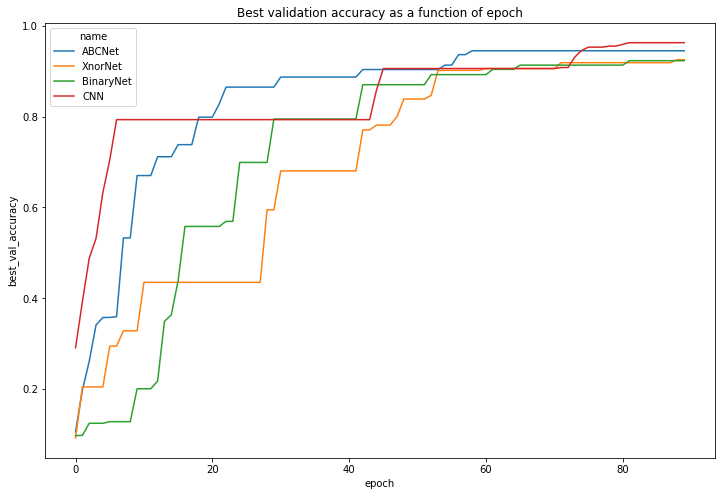

In [111]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data=results,x="epoch",y="best_val_accuracy",hue="name",ax=ax)
ax.set_title("Best validation accuracy as a function of epoch")

Text(0.5, 1.0, 'Training accuracy as a function of the epoch')

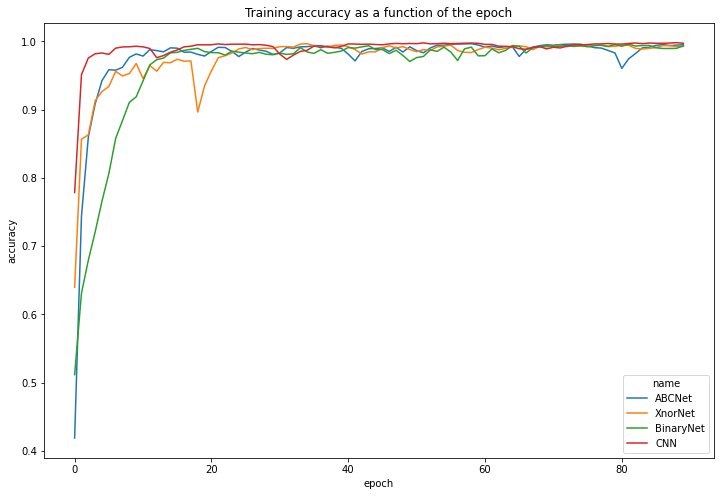

In [112]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data=results,x="epoch",y="accuracy",hue="name",ax=ax)
ax.set_title("Training accuracy as a function of the epoch")

#ax.yaxis.((0,1))

Text(0.5, 1.0, 'Training loss as a function of the epoch')

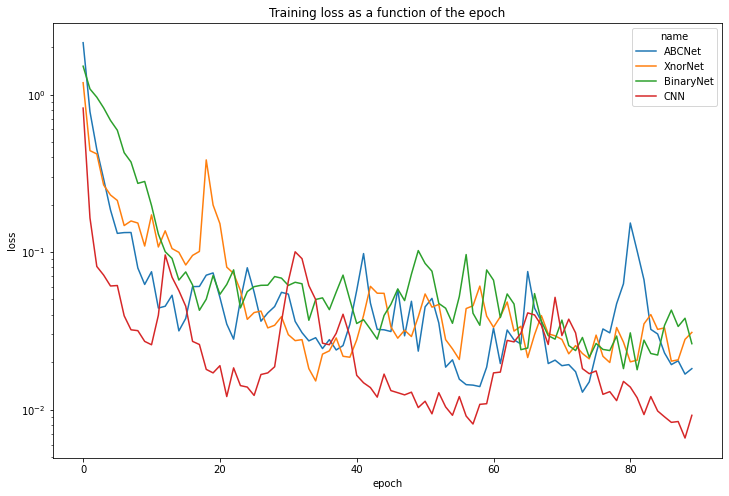

In [87]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data=results,x="epoch",y="loss",hue="name",ax=ax)
ax.set_yscale('log')
ax.set_title("Training loss as a function of the epoch")

#ax.yaxis.((0,1))

Text(0.5, 1.0, 'Validation loss as a function of the epoch')

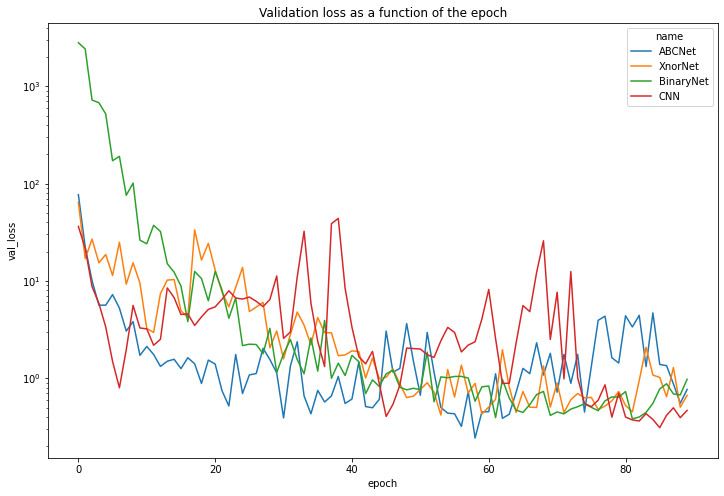

In [113]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.lineplot(data=results,x="epoch",y="val_loss",hue="name",ax=ax)
ax.set_yscale('log')
ax.set_title("Validation loss as a function of the epoch")

#ax.yaxis.((0,1))

Text(0.5, 1.0, 'Estimated $\\mathregular{CO_2}$ emission rate on training')

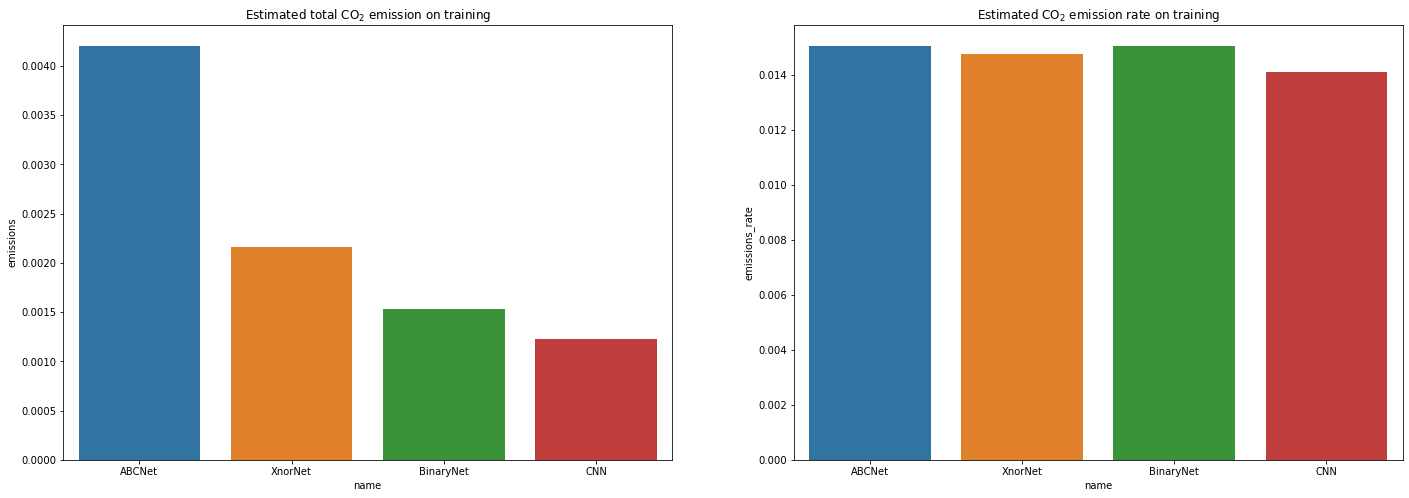

In [132]:
fig,axs=plt.subplots(1,2,figsize=(24,8))
sns.barplot(data=results,x="name",y="emissions",ax=axs[0])
sns.barplot(data=results,x="name",y="emissions_rate",ax=axs[1])
axs[0].set_title(R"Estimated total $\mathregular{CO_2}$ emission on training")
axs[1].set_title(R"Estimated $\mathregular{CO_2}$ emission rate on training")

Text(0.5, 1.0, 'Training time')

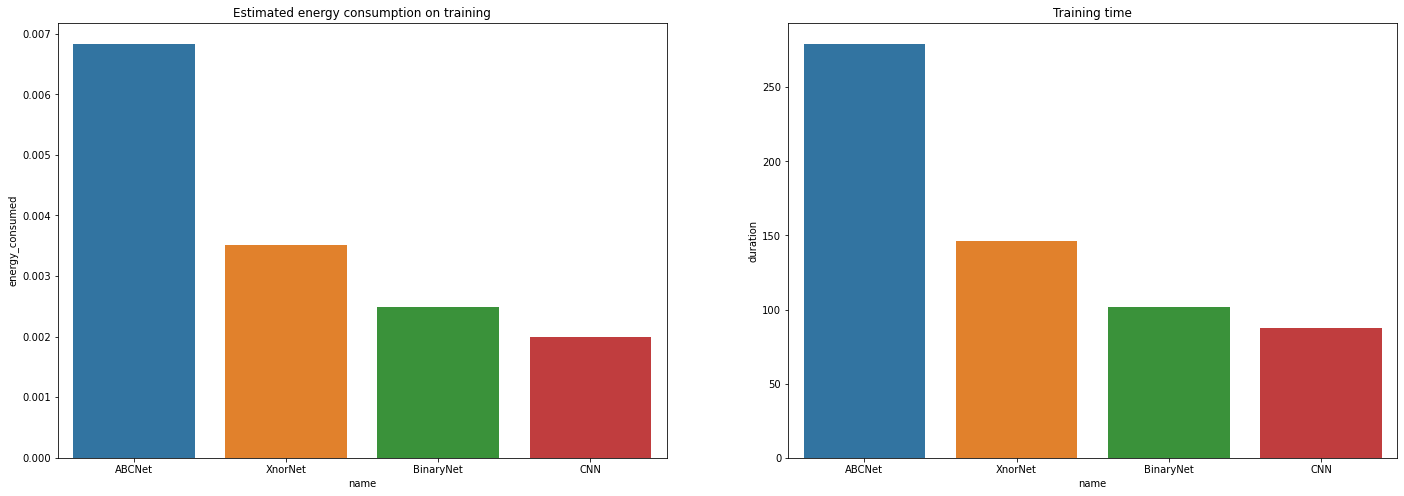

In [135]:
fig,axs=plt.subplots(1,2,figsize=(24,8))
sns.barplot(data=results,x="name",y="energy_consumed",ax=axs[0])
sns.barplot(data=results,x="name",y="duration",ax=axs[1])
axs[0].set_title(R"Estimated energy consumption on training")
axs[1].set_title(R"Training time")